#Assigment 3: Identifying cracks and damages in structures (Concrete structures)
<br>42028 Deep Learning and Convolutional Neural Network - Autumn 2020

<br>Carlos Mario Carvajal Moreno. Student ID: 13144148
<br>Andres Felipe Lagos. Student ID: 13092248
<br>Ernest Ilustre.  Student ID: 12763239

In [1]:
#Connecting to Google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#Importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
cd /content/gdrive/My Drive/A3 

/content/gdrive/My Drive/A3


In [4]:
ls

A3_CNN_Multiclass.ipynb      VGG16_A3_CNN_Wall.ipynb
Concrete_Data_Final.zip      VGG19_A3_CNN_Deck.ipynb
multiclass_model.json        VGG19_A3_CNN_Pavement.ipynb
pavement_model.json          VGG19_A3_CNN_Wall.ipynb
VGG16_A3_CNN_Deck.ipynb      wall_model.json
VGG16_A3_CNN_Pavement.ipynb  Weights/


In [0]:
#Extraction of data and placing it in the temporary folder. The models work a lot better
local_zip = '/content/gdrive/My Drive/A3/Concrete_Data_Final.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
#Setting the path directory for training and validation sets
base_dir = '/tmp/Concrete_Data_Final'
train_dir = os.path.join(base_dir, 'Train/Deck')
validation_dir = os.path.join(base_dir, 'Val/Deck')
test_dir = os.path.join(base_dir, 'Test/Deck')

#Train
# Directory with training Deck Cracked Pictures
train_cracked_dir = os.path.join(train_dir, 'Cracked')
# Directory with training Deck Uncracked Pictures
train_Uncracked_dir = os.path.join(train_dir, 'Uncracked')


#Val
# Directory with validation Deck Cracked pictures
val_cracked_dir = os.path.join(validation_dir, 'Cracked')
# Directory with validation Deck Uncracked pictures
val_Uncracked_dir = os.path.join(validation_dir, 'Uncracked')


#Test
# Directory with validation Deck Cracked pictures
test_cracked_dir = os.path.join(test_dir, 'Cracked')
# Directory with validation Deck Uncracked pictures
test_Uncracked_dir = os.path.join(test_dir, 'Uncracked')

In [7]:
# All images are rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   brightness_range = (0.9,1.1),
                                   fill_mode='nearest'
                                   )
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16
image_size = 256

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),  # Images are size 100X100
        batch_size= batch_size,
        class_mode='binary')

# Flow validation images in batches of 16 using test_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='binary')

# Flow validation images in batches of 16 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='binary')

Found 3547 images belonging to 2 classes.
Found 831 images belonging to 2 classes.
Found 9242 images belonging to 2 classes.


In [8]:
class_dict = train_generator.class_indices
class_dict

{'Cracked': 0, 'Uncracked': 1}

In [9]:
#Downloading the inception ResNet V2 model with imagenet weights
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
conv_base.summary()
for layer in conv_base.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in conv_base.layers:
    print(layer, layer.trainable)


model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [0]:
#compiling the model
model.compile(optimizer= optimizers.Adam(learning_rate=0.001),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [0]:
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1, period=3)
filepath='/content/gdrive/My Drive/A3/Weights/Deck_weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint= ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
json_string  = model.to_json()
f = open("deck_model.json", 'w')
f.write(json_string)
f.close()

In [14]:
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch= train_generator.n//train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps= validation_generator.n//train_generator.batch_size,
      callbacks = [checkpoint],
      verbose=1,
      )

Epoch 1/20
221/221 [==============================] - 67s 301ms/step - loss: 0.6515 - accuracy: 0.6888 - val_loss: 1.0962 - val_accuracy: 0.5184
Epoch 2/20
221/221 [==============================] - 63s 283ms/step - loss: 0.5180 - accuracy: 0.7675 - val_loss: 1.1110 - val_accuracy: 0.6466
Epoch 3/20
221/221 [==============================] - 62s 280ms/step - loss: 0.4941 - accuracy: 0.7732 - val_loss: 0.4219 - val_accuracy: 0.7129
Epoch 4/20
221/221 [==============================] - 62s 280ms/step - loss: 0.4761 - accuracy: 0.7859 - val_loss: 0.4306 - val_accuracy: 0.7411
Epoch 5/20
221/221 [==============================] - 61s 276ms/step - loss: 0.4649 - accuracy: 0.7924 - val_loss: 0.3623 - val_accuracy: 0.7472
Epoch 6/20
221/221 [==============================] - 61s 278ms/step - loss: 0.4523 - accuracy: 0.8040 - val_loss: 8.0694 - val_accuracy: 0.7693
Epoch 7/20
221/221 [==============================] - 61s 277ms/step - loss: 0.4579 - accuracy: 0.7950 - val_loss: 0.4971 - val_ac

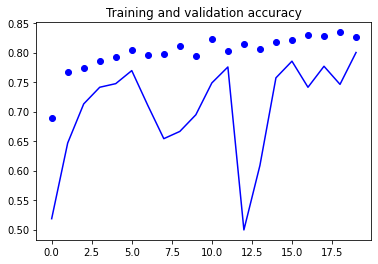

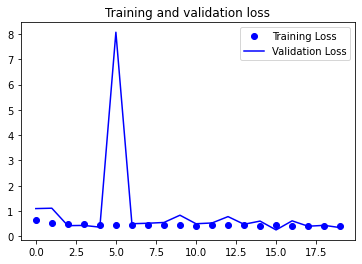

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
test_loss, test_acc = model.evaluate(test_generator)
test_acc

578/578 [==============================] - 31s 53ms/step


0.8910409212112427

## Loading a saved model.

In [0]:
## Go to the /tmp folder and copy the name of the last saved model
#modelv2=tf.keras.models.load_model('/content/drive/My Drive/Weights/Pavement_weights.10-0.26.hdf5')

In [0]:
#compiling the model
#modelv2.compile(optimizer= tf.keras.optimizers.Adamax(learning_rate=0.001),
              #loss= 'binary_crossentropy',
              #               metrics=['accuracy'])

In [0]:
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1, period=3)
#epath='/content/drive/My Drive/Weights/Pavement_weights2.{epoch:02d}-{val_loss:.2f}.hdf5'
#checkpoint= ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [0]:
# Train the model
history = modelv2.fit(
      train_generator,
      steps_per_epoch= train_generator.n//train_generator.batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps= validation_generator.n//train_generator.batch_size,
      #callbacks = [checkpoint],
      verbose=1,
      )